In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest, f_classif
import pylab
import scipy
import sklearn
import time
import seaborn as sns
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

In [2]:
pd.set_option("display.max_rows", 250000)

In [3]:
df = pd.read_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/GSE59114.csv', header = 1)
df1 = df.T
df1.columns = df1.loc['Gene Symbol'].reset_index()
df1 = df1.drop(['Gene Symbol', 'UCSC transcripts'])
df1.columns = [x[1] for x in df1.columns]
df1.columns = df1.columns.str.replace("'", "")
df1.shape

(1434, 8422)

Itgam, Ly6g, Ptprc, Cd3e, Ly76, Kit, Ly6a, Cd48, Slamf1

In [4]:
import re
df1_1 = df1[~df1.index.str.contains('biol_replicate')]
df1_1 = df1_1.drop(['\'Young LT-HSC\'','\'Young ST-HSC\'', '\'Young MPP\'','\'Old LT-HSC\'', '\'Old ST-HSC\'','Old MPP\''])
df1_1 = df1_1.drop(['Itgam', 'Ptprc', 'Kit', 'Ly6a', 'Cd48', 'Slamf1'], axis = 1)

In [5]:
df1_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1058 entries, young_LT_HSC_2 to old_MPP_168
Columns: 8416 entries, Npl to Sft2d1
dtypes: object(8416)
memory usage: 67.9+ MB


In [6]:
df1_1.index = df1_1.index.str.replace(r'[^a-zA-Z]', '')

print((df1_1.columns).shape)
print(np.unique(df1_1.columns).shape)

(8416,)
(8351,)


In [7]:
df1_1dup = df1_1[df1_1.loc[:,df1_1.columns.duplicated()].columns]


In [8]:
dupcols = np.unique(df1_1dup.columns)
dupcols

array(['Abcg2', 'Arih1', 'Atf7ip', 'Atrip', 'Brwd1', 'Cbx1', 'Ccnd3',
       'Cdk6', 'Celf1', 'Commd1', 'Csnk1a1', 'Ctse', 'Dnajb6', 'Eci2',
       'Eif1ax', 'Fgd4', 'Fus', 'G3bp1', 'Glod4', 'Gm10598', 'Gm13215',
       'Hjurp', 'Ikbkb', 'Ing4', 'Itga4', 'Itga6', 'Kansl2', 'Lcor',
       'Lrrc29', 'Luc7l2', 'Mafg', 'Mecom', 'Mob1a', 'Mtcp1', 'Nagk',
       'Ndufa3', 'Pafah1b1', 'Patz1', 'Pcif1', 'Pik3ip1', 'Psme4', 'Pten',
       'Ramp2', 'Rpl24', 'Rspry1', 'Satb1', 'Smarcc2', 'Srcap', 'Srsf10',
       'Sugp2', 'Taf9', 'Tex261', 'Tmem167b', 'Tmem181b-ps', 'Trappc9',
       'Trim30b', 'U2af1l4', 'Utp23', 'Wwp2', 'Zbtb20', 'Zfp708',
       'Zfp869', 'Zgpat'], dtype=object)

In [9]:
df1_1dupgroup = df1_1dup.groupby(df1_1dup.columns, axis=1).sum()

In [10]:
df1_1dupmean = pd.DataFrame()
for x in dupcols:
    df1_1dupmean[x] = df1_1dupgroup[x]/df1_1dup.columns.tolist().count(x)


In [11]:
# cols = []
# n = 1
# for x in df2dup.columns:
#     if x in cols:
#         cols.append(x+'.'+str(n))
#         n += 1
#     else:
#         cols.append(x)
#         n = 1


In [12]:
dfnodup = df1_1.loc[:,~df1_1.columns.duplicated()].drop(dupcols, axis = 1)

df2 = pd.concat([dfnodup, df1_1dupmean], axis = 1)

df2= df2.round(2)
df2.shape

(1058, 8351)

In [14]:
genefracs = (df2==0).sum()/(df2==0).count()
passindex = genefracs[genefracs < 0.20]


In [87]:
genefracs.sort_values()

Rps23                                                                                                 0.000000
Rpl4                                                                                                  0.000000
uc007yyn.2                                                                                            0.000000
Pikfyve                                                                                               0.000000
Eef2                                                                                                  0.000000
Rpl13                                                                                                 0.000000
Rpl32                                                                                                 0.000000
Mmp12                                                                                                 0.000000
Traf5                                                                                                 0.000000
u

In [15]:
zifa = df2[passindex.index]
zifa= np.round(zifa.astype(np.float64),4)
zifa = np.array(zifa)
zifa.shape

(1058, 1052)

In [16]:
from ZIFA import ZIFA
from ZIFA import block_ZIFA

In [17]:
start_time = time.time()
Z, model_params = block_ZIFA.fitModel(zifa, 10)
print("--- %s seconds ---" % (time.time() - start_time))

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 2
Running block zero-inflated factor analysis with N = 1058, D = 1052, K = 10, n_blocks = 2
Block sizes [526, 526]
Param change below threshold 1.000e-02 after 8 iterations
--- 146.34361100196838 seconds ---


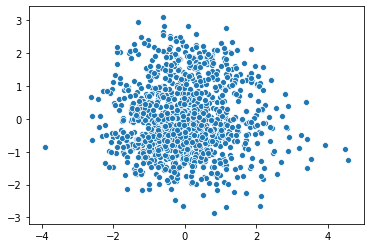

In [89]:
dfz = pd.DataFrame(Z, index = df2.index)
pcaz = PCA(n_components=3, random_state = 42)

zcomps = pcaz.fit_transform(dfz)
sns.scatterplot(zcomps[:,0], zcomps[:,1])
plt.show()

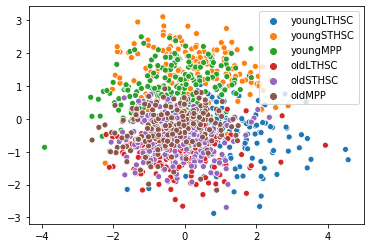

In [90]:
sns.scatterplot(zcomps[:,0], zcomps[:,1], hue = dfz.index)
plt.show()

In [118]:
encoded = {'oldLTHSC':0, 'oldMPP':1, 'oldSTHSC':2, 'youngLTHSC':3, 'youngMPP':4, 'youngSTHSC':5}
cells = ['oldLTHSC' ,'oldMPP', 'oldSTHSC', 'youngLTHSC' ,'youngMPP' ,'youngSTHSC']
cell_types = [encoded.get(x, x) for x in dfz.index]
colormap = ['r', 'b', 'g', 'y', 'c', 'm']
cell_colors = [colormap[x] for x in cell_types]
dfpca = pd.DataFrame(zcomps, index = dfz.index)
dfpca
fig = px.scatter_3d(dfpca, zcomps[:,0], zcomps[:,1],zcomps[:,2], dfpca.index)
fig.update_traces(marker=dict(opacity =1, size=4,
                              line=dict(width= .1)))

fig.show()

In [91]:
np.cov(dfz)

array([[ 1.10473322e+00,  6.95414806e-01,  1.02779344e+00, ...,
         1.40842538e-02, -6.00262276e-04,  9.14233887e-03],
       [ 6.95414806e-01,  9.13440355e-01,  9.30332160e-01, ...,
        -2.77836218e-01, -4.87913552e-02, -4.93564183e-01],
       [ 1.02779344e+00,  9.30332160e-01,  1.52239113e+00, ...,
        -1.80833487e-01,  1.11051928e-01, -4.50412429e-01],
       ...,
       [ 1.40842538e-02, -2.77836218e-01, -1.80833487e-01, ...,
         3.36454431e-01,  6.91115068e-02,  4.10604593e-01],
       [-6.00262276e-04, -4.87913552e-02,  1.11051928e-01, ...,
         6.91115068e-02,  2.35027127e-01,  4.19758529e-02],
       [ 9.14233887e-03, -4.93564183e-01, -4.50412429e-01, ...,
         4.10604593e-01,  4.19758529e-02,  7.54458684e-01]])

Text(0.5, 1.0, 'ZIFA-UMAP (10 dim): genes with fewer than 20% zeros')

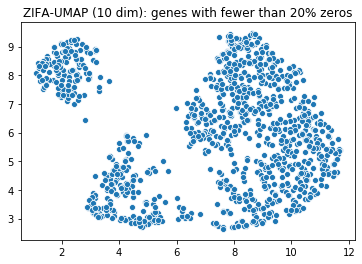

In [112]:
zumap = umap.UMAP(n_neighbors=20,
                      min_dist=.2,
                      metric='euclidean').fit_transform(dfz)
fig = sns.scatterplot(zumap[:,0], zumap[:,1])
fig.set_title('ZIFA-UMAP (10 dim): genes with fewer than 20% zeros')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

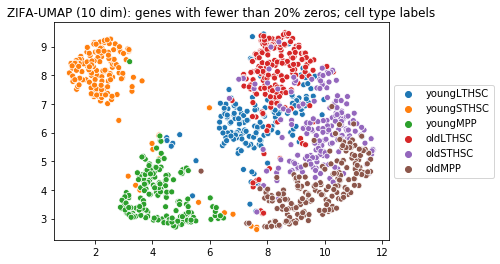

In [114]:
fig = sns.scatterplot(zumap[:,0], zumap[:,1], hue = dfz.index)

fig.set_title('ZIFA-UMAP (10 dim): genes with fewer than 20% zeros; cell type labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [98]:
gmm = GaussianMixture(n_components = 6)
gmm.fit(dfz)
cluster = gmm.fit_predict(dfz)


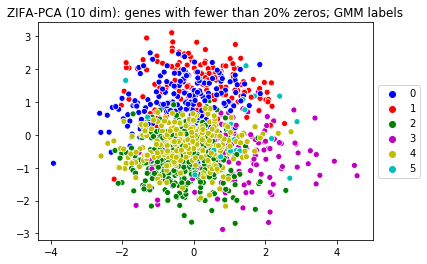

In [119]:
fig = sns.scatterplot(zcomps[:,0], zcomps[:,1], hue = cluster, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-PCA (10 dim): genes with fewer than 20% zeros; GMM labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

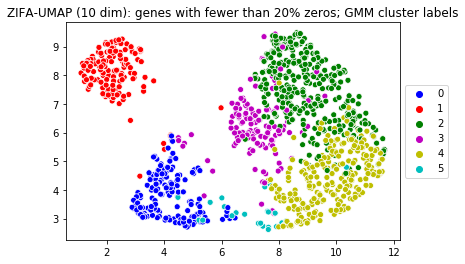

In [115]:
fig = sns.scatterplot(zumap[:,0], zumap[:,1], hue = cluster, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-UMAP (10 dim): genes with fewer than 20% zeros; GMM cluster labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [102]:
km = KMeans(n_clusters = 6, random_state=42)
kmdata = km.fit_transform(dfz)
kpred = km.fit_predict(dfz)

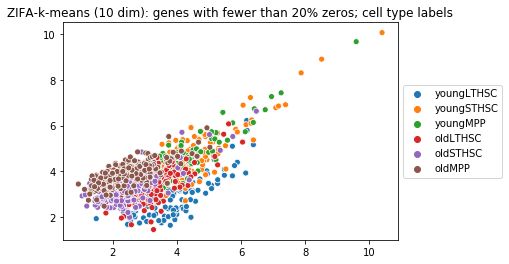

In [121]:
fig = sns.scatterplot(kmdata[:,0], kmdata[:,1], hue = dfz.index)
fig.set_title('ZIFA-k-means (10 dim): genes with fewer than 20% zeros; cell type labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

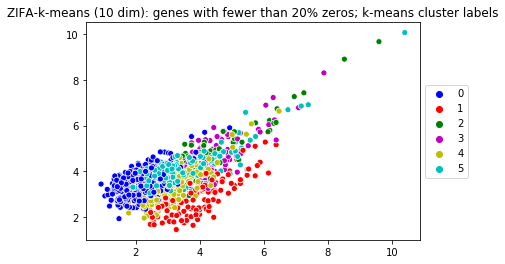

In [122]:
fig = sns.scatterplot(kmdata[:,0], kmdata[:, 1], hue = kpred, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-k-means (10 dim): genes with fewer than 20% zeros; k-means cluster labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [105]:
pd.crosstab(dfz.index, kpred)

col_0         0   1    2    3    4   5
row_0                                 
oldLTHSC      5  12    0    0  157   9
oldMPP      125   1    0    0    1  61
oldSTHSC    144  12    0    0   26   7
youngLTHSC    4  84    5    0   67   7
youngMPP      0   0  124    1    0  43
youngSTHSC    0   4   12  140    0   7

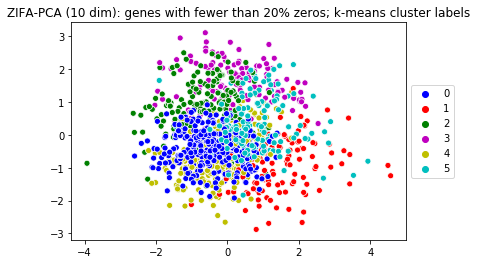

In [123]:
fig = sns.scatterplot(zcomps[:,0], zcomps[:,1], hue = kpred, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-PCA (10 dim): genes with fewer than 20% zeros; k-means cluster labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

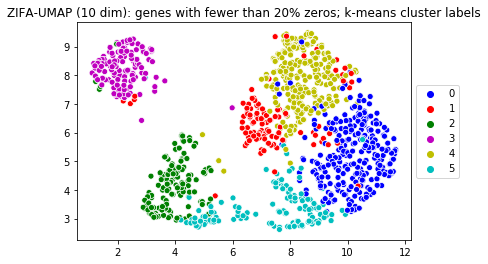

In [116]:
fig = sns.scatterplot(zumap[:,0], zumap[:,1], hue = kpred, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-UMAP (10 dim): genes with fewer than 20% zeros; k-means cluster labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

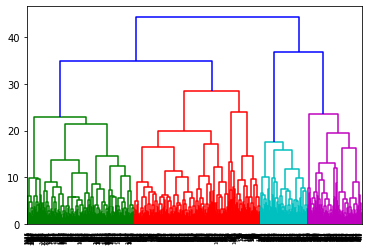

In [108]:
dendrogram(linkage(dfz, method = 'ward'))
plt.show()

In [109]:
dfcelltypes = pd.DataFrame(df2.mean(), columns = ['All cell average'])
dfcelltypes['youngLTHSC'] = df2[df2.index == 'youngLTHSC'].mean()
dfcelltypes['youngSTHSC'] = df2[df2.index == 'youngSTHSC'].mean()
dfcelltypes['youngMPP'] = df2[df2.index == 'youngMPP'].mean()
dfcelltypes['oldLTHSC'] = df2[df2.index == 'oldLTHSC'].mean()
dfcelltypes['oldSTHSC'] = df2[df2.index == 'oldSTHSC'].mean()
dfcelltypes['oldMPP'] = df2[df2.index == 'oldMPP'].mean()


In [110]:
dfcellbroad = pd.DataFrame(df2.mean(), columns = ['All cell average'])
dfcellbroad['HSC'] = df2[df2.index.str.contains('HSC')].mean()
dfcellbroad['MPP'] = df2[df2.index.str.contains('MPP')].mean()
dfcellbroad['HSC/MPP'] = dfcellbroad['HSC']/dfcellbroad['MPP']
dfcellbroad.sort_values(by = ['HSC/MPP','HSC','MPP'], ascending = False).head(25000)


All cell average  \
Efna1                                                       0.643544   
Epor                                                        0.195877   
A230065H16Rik                                               0.188853   
Entpd2                                                      0.118546   
uc012bnh.1                                                  0.012621   
Chst2                                                       0.390360   
Tenc1                                                       0.414738   
Sytl5                                                       0.261054   
Smtnl1                                                      0.344110   
Fkbp10                                                      0.207363   
Trim47                                                      0.618175   
Sdpr                                                        1.132630   
Prom2                                                       0.127064   
Gstm2                                                       0.393672   
Cldn5                                                       0.133280   
Nupr1                                                       2.090327   
Gpx3                                                        0.422264   
D630039A03Rik                                               0.693411   
Plxdc2                                                      0.888490   
Clip3                                                       0.347333   
Pde6h                                                       0.221191   
uc007cvp.1,uc007cvq.1                                       0.324404   
Snrpn                                                       0.428033   
Upp1                                                        0.927185   
Gm13986                                                     0.386996   
Ndn                                                         1.065439   
Tgm2                                                        2.373461   
Sult1a1                                                     1.656241   
Hid1                                                        0.731313   
Tgfb3                                                       0.188622   
Zfp612                                                      0.548159   
Eno2                                                        0.214290   
Hba-a2                                                      0.698456   
Mt2                                                         0.389157   
Tinagl1                                                     1.058981   
Reep2                                                       0.324417   
Ehd3                                                        0.907648   
Fam46c                                                      0.120244   
Fam110c                                                     0.711369   
Abcg3                                                       2.109270   
Clca1                                                       0.969792   
Vwf                                                         1.211336   
Clec1a                                                      1.491799   
Hbb-b1                                                      0.696732   
Kazald1                                                     0.335396   
Ocln                                                        0.451780   
Rprm                                                        0.116883   
Npdc1                                                       1.094193   
Mmrn1                                                       4.407780   
Clu                                                         1.038810   
Wfdc2                                                       0.509162   
Grb10                                                       2.193117   
Rhd                                                         0.059553   
Hgfac                                                       0.722850   
Gimap4                                                      0.461725   
Abcb1a              